# Setup

```
pip install git+https://github.com/scverse/spatialdata.git@main
pip install git+https://github.com/scverse/spatialdata-io.git@main
```

This is the stuff you have to edit; the rest of the sections can run as-is after you've set the needed parameters.

---

`coord_suffix` must align with 
* the sub-directory (corresponds to region, e.g., "mucosa") under the `dir_coord` directory where the Xenium Explorer-exported selection files are stored, and
* the suffixes of the coordinate selection files (see file naming conventions below).
  
The `AnnData` objects created will have this suffix as well (e.g., `Uninflamed-50452A_mucosa.h5ad`).

---

Selection files should be named by this convention:
`<library_id>_<coord_suffix>.csv`.

For example, if `dir_coord` is `.../coordinates/mucosa`, the mucosa selection file for sample 50452A should be under `.../coordinates/mucosa/50452A_mucosa.csv`. 

More specifically, if the coordinates directory is under `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates`, and the selection region is "mucosa,"`dir_coord` should be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa`, and the full file path for this sample would be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa/50452A_mucosa.csv`.

---

**As with any other file naming schema, suffixes/directory names should not any special characters other than underscores (`_`) (no periods, dashes, spaces, etc.).**

N.B. In the above explanation, `library_id` refers to library/original sample ID without condition (e.g., "50452A", not "Uninflamed-50452A" like in other places). Remember that `coord_suffix` should also be the name of the parent directory of the coordinate file. I include this information in both the directory and file name to prevent mix-ups should files be moved or placed in the wrong folder.

Loading the metadata allows us to find the object IDs (e.g., for TUQ97N, object IDs are in the format <condition (Inflamed/Uninflamed/Stricture)><block_id>) corresponding to the sample IDs.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import traceback
import anndata
import scanpy as sc
# import spatialdata_plot
import numpy as np
import pandas as pd
import corescpy as cr

# Main
write_object = True  # change to True when you're ready to save objects
overwrite = False  # overwrite if already exists?
regions = ["mucosa", "serosa", "myenteric_plexus", "submucosa",
           "smc_circular", "smc_longitudinal"]
col_leiden = "leiden_res1pt5_dist0_npc30"
col_ann = "Bucket"
cells_as_circles = True
allow_make_valid = True  # allow shapely package to correct invalid geometries

# Process Options
panel = "TUQ97N"  # Xenium panel ID
constants_dict = cr.get_panel_constants(panel_id=panel)
# libs = [  # sample IDs from patients for whom we have all conditions
#     "50452A", "50452B", "50452C",  # old segmentation
#     "50006A", "50006B", "50006C",  # rest are new segmentation
#     "50217A", "50217B", "50217C",
#     "50336B", "50336C", "50336A",
#     "50403A2", "50403B", "50403C1"
# ]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
        "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
# libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area

# Files & Directories
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with data
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_"
          f"{panel}.csv")  # metadata file path (for now; will soon be on NFS)
dir_writeable = os.path.join(
    dir_entry, f"elizabeth/data/shared-xenium-library")  # where objects are
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel}/nebraska")  # object output directory

#  Your Folders
out_new = os.path.join(
    dir_entry,
    f"{os.getlogin()}/data/shared-xenium-library/outputs/{panel}/nebraska")

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
os.makedirs(out_dir, exist_ok=True)  # make output directory if needed
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs)
metadata[col_subject]

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Sample
Inflamed-50006A       50006
Uninflamed-50006B     50006
Inflamed-50217A       50217
Uninflamed-50217B     50217
Inflamed-50336B       50336
Uninflamed-50336C     50336
Inflamed-50403B       50403
Uninflamed-50403A2    50403
Name: subject_id, dtype: int64

# Subset Data by Coordinate Files & Write Cropped Objects

Subset the data by coordinates (`corescpy` can use Xenium Explorer-exported manual selection files to get those coordinates) and then write the cropped objects to `out_dir/<coord_suffix>`.



50006A




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022407__50006A-TUQ97N-EA__20240411__205514/
         cell_feature_matrix.h5                                                                                    


Counts: Initial


	Observations: 297656

	Genes: 469







 AnnData object with n_obs × n_vars = 297656 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols          

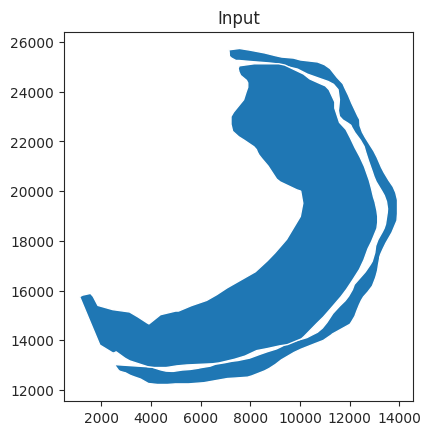

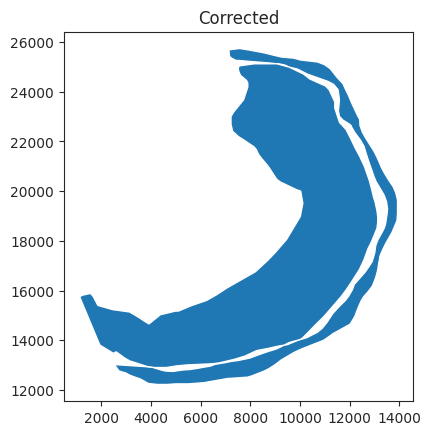



50006B


*** All subsets /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Uninflamed-50006B_mucosa.h5ad, /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/serosa/Uninflamed-50006B_serosa.h5ad, /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/myenteric_plexus/Uninflamed-50006B_myenteric_plexus.h5ad, /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/submucosa/Uninflamed-50006B_submucosa.h5ad, /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_circular/Uninflamed-50006B_smc_circular.h5ad, /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Uninflamed-50006B_smc_longitudinal.h5ad already exist


50217A


*** All subsets /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/

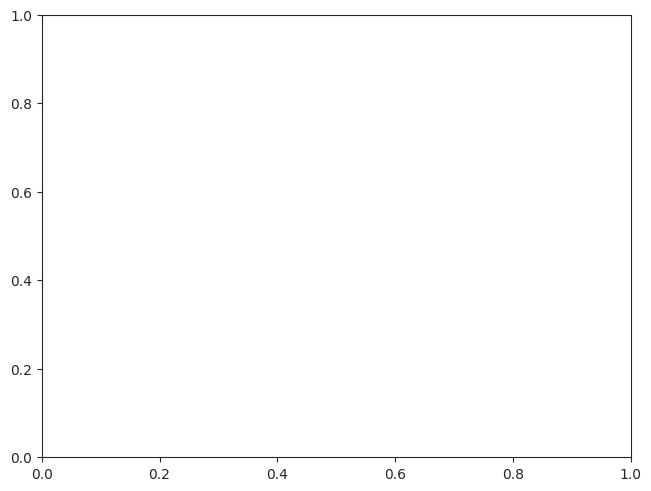

In [81]:
for s in libs:  # iterate samples
    print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    if overwrite is False:  # skip entirely if all crops exist & no overwrite
        all_files = [os.path.join(out_new, "objects_cropped",
                                  r, f'{lib}_{r}.h5ad') for r in regions]
        if all([os.path.exists(r) for r in all_files]):
            print(f"*** All subsets {', '.join(all_files)} already exist")
            continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # self.update_from_h5ad(file_obj_proc)  # update with processed object
    for coord_suffix in regions:
        print(f"\n\n\t\t{'*' * 40}\n\t\t{s}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        if overwrite is False and os.path.exists(file_obj_crop):
            print(f"*** Subset {file_obj_crop} already exists")
            continue
        if not os.path.exists(file_coord):
            print(f"*** Coordinate file {file_coord} doesn't exist")
            continue
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        try:
            sdata = self.crop(
                file_coord, allow_make_valid=allow_make_valid)  # crop
            i_x = sdata.table.obs["cell_id"].copy()
            del sdata.table
            sdata.table = adata[adata.obs["cell_id"].isin(i_x[
                i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered
            if plot:
                try:
                    sdata.pl.render_labels("cell_labels").pl.show()  # plot
                except Exception:
                    pass
            self.adata = sdata
            if write_object is True:
                self.write(file_obj_crop)  # write cropped
        except Exception:
            print(traceback.format_exc(), f"Cropping \n\n{s} failed!")
print("\n\nCompleted!")

# Workspace

In [ ]:
self.adata.shapes["cell_circles"]["radius"].isna().sum()

In [ ]:
self.rna[self.rna.obs["cell_id"].isin(sdata.shapes["cell_boundaries"].index)]

In [ ]:
self.adata.get_annotated_regions(self.adata.table)

In [ ]:
from spatialdata_io._constants._constants import XeniumKeys

transform = Scale([1.0 / 0.2125, 1.0 / 0.2125], axes=("x", "y"))
radii = np.sqrt(self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA].to_numpy() / np.pi)

In [ ]:
self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA]

In [ ]:
[i[1] for i in self.adata._gen_elements()]

In [ ]:
found_regions = set(table.obs["cell_id"].unique().tolist())
target_element_set = ["cell_boundaries"]
symmetric_difference = found_regions.symmetric_difference(target_element_set)
len(symmetric_difference)

In [ ]:
self.adata._change_table_annotation_target(self.adata.table, "cell_labels")

In [ ]:
table.uns.get("spatialdata_attrs")

In [ ]:
self.adata.set_table_annotates_spatialelement("table", region="cell_labels")

In [ ]:
# element = self.adata.shapes["cell_circles"]
# buffered_df = element.copy()
# buffered = to_polygons(element)

In [51]:
# coord_suffix = "myenteric_plexus"
# coord_suffix = "smc_circular"
coord_suffix = "smc_longitudinal"
# s = "50006B"
# s =  "50217A"
# s = "50217B"

# for s in ["50006A", "50217A", "50403B"]:
for s in ["50006A"]:
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    dir_coord = os.path.join(
        out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
    out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
    os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
    file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
    file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
    if os.path.exists(file_obj_crop):
        continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # coords = cr.pp.xenium_explorer_selection(file_coord, pixel_size=0.2125)
    # if isinstance(coords, list):  # if multiple selections...
    #     coords = shapely.MultiPolygon(coords)  # ...union of areas
    # kws = {"target_coordinate_system": "global", "filter_table": True}
    # try:
    #     sdata = self.adata.query.polygon(coords, **kws)  # crop
    # except Exception as err:
    #     if allow_make_valid:
    #         warn("\n\n*** Invalid geometry! Making geometry valid."
    #              "Check new coordinates!\n\n")
    #         coords_new = shapely.validation.make_valid(coords)
    #         sdata = self.adata.query.polygon(coords_new, **kws)  # crop
    #     else:
    #         raise err
    # i_x = sdata.table.obs["cell_id"].copy()
    # del sdata.table
    # sdata.table = adata[adata.obs["cell_id"].isin(i_x[
    #     i_x.isin(adata.obs["cell_id"])])]
    sdata = self.crop(file_coord, allow_make_valid=allow_make_valid)
    if not os.path.exists(file_obj_crop):
        sdata.tables["table"].write_h5ad(os.path.join(
            out, f"{self._library_id}_{coord_suffix}.h5ad"))



<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022407__50006A-TUQ97N-EA__20240411__205514/
         cell_feature_matrix.h5                                                                                    


KeyboardInterrupt: 

In [ ]:
import geopandas as gpd
import shapely

#Create a test dataframe
    #The first line is valid, the second is not, it starts and ends at the same point
wkts  = ["LINESTRING (30 10, 10 30, 40 40)", "LINESTRING (30 10, 30 10)"]
geometries = [shapely.wkt.loads(x) for x in wkts] #Create shapely geometries
df = gpd.GeoDataFrame(geometry=geometries) #And a data frame

invalid = df.loc[~df.geometry.is_valid]

In [12]:
from shapely.validation import make_valid

In [ ]:
import squidpy as sq

sq.pl.spatial_scatter(sdata_crop.table)

In [ ]:
sdata.pl.render_labels("cell_labels").pl.show()  # plot

In [ ]:
elements = self.gen_spatial_elements()

In [ ]:
cr.pp.xenium_explorer_selection(file_coord)